# Estimating Return Period

This code example deals with estimating return period for specific value of hydrological variable (annual maximum flood in our case). Following three methods are covered in this code.

1. Sample estimate of return period
2. Plotting Position Formula
3. Probability Paper

At first, the required libraries are imported and some functions required to process the data are defined.

In [1]:
# Intialization: Import required libraries
import os

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Configuration for plotting and data file
plt.style.use('ggplot')
plt.rcParams['text.usetex'] = True
FIGURE_FOLDER = os.path.join('output', 'figures')
os.makedirs(FIGURE_FOLDER, exist_ok=True)
DATA_FILE=os.path.join('data','Gauge-Discharge Data Jondhra,1980-2019.csv')

## Functions for finding maxima in time series
The following python functions can extract the maximum values from a hydrological time series. The description of all functions is provided in the first line of function body (enclosed by """...""").

In [2]:
# Functions for extracting maxima values from the hydrological time series
def check_1D_timeseries(data):
    """Check if the input is a valid time series"""
    if not isinstance(data, pd.Series):
        raise ValueError('This function only works with pandas Series.')
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError('This function only works with time series.')


def get_water_year(date):
    """Given a timeseries return water year for each value."""
    date = pd.to_datetime(date)
    # Water year start in June and ends in May next year
    water_yr = np.where(date.month >= 6, date.year, date.year-1)
    return water_yr


def find_year_maxima(data):
    """Find maximum value for different water years."""
    # Check if data is time series
    check_1D_timeseries(data)

    year_maxima = data.groupby(get_water_year(data.index)).max()
    max_flow_dates = data.groupby(get_water_year(data.index)).idxmax()

    return year_maxima, max_flow_dates


def find_exceedance(data, quantile=0.95):
    """Find values in time series above some quantile."""
    # Check if data is time series
    check_1D_timeseries(data)

    return data[data >= data.quantile(q=quantile)]

## Functions for Plotting Position formula
Following functions calculate the exceedance probability as per different plotting position formula. Four plotting position formula are given in this example.


In [3]:
def _plotting_pos_california(m, N):
    return m/N


def _plotting_pos_weibull(m, N):
    return m/(N+1)


def _plotting_pos_hazen(m, N):
    return (m-0.5)/N


def _plotting_pos_chegodayev(m, N):
    return (m-0.3)/(N+0.4)


def plotting_position(year_maxima, method='weibull'):
    """Returns exceedence probability for annual maxima series."""
    method = method.lower()
    if method not in {'california', 'weibull', 'hazen', 'chegodayev'}:
        raise ValueError(f'{method} not supported.')
    method_func = {'california': _plotting_pos_california,
                   'weibull': _plotting_pos_weibull,
                   'hazen': _plotting_pos_hazen,
                   'chegodayev': _plotting_pos_chegodayev}
    maxima_val = year_maxima.values
    maxima_val_sorted = np.sort(maxima_val)[::-1]
    m = np.arange(start=1, stop=len(maxima_val)+1)
    N = len(maxima_val)
    P = method_func[method](m, N)

    return maxima_val_sorted, P

## Data Reading

Data for daily flow (in cumec) is read from `data/Gauge-Discharge Data Jondhra,1980-2019.csv` file. Furthermore, annual maxima of the data is also calculated.

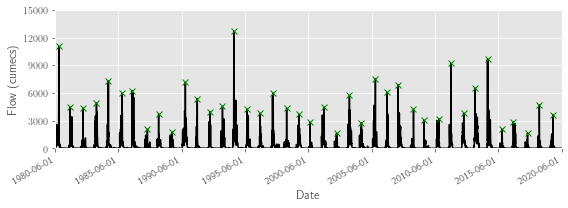

In [4]:
_data = pd.read_csv(DATA_FILE, index_col='Dates')
data = _data['01-06-1980':'31-05-2020']['Flow in cumecs']
data.index = pd.to_datetime(data.index, format='%d-%m-%Y')

year_maxima, max_flow_dates = find_year_maxima(data)

# Time series plot with annual maxima marked
fig = plt.figure(figsize=[8, 3])
data.plot(ax=plt.gca(), color='k')
plt.plot(max_flow_dates.values, year_maxima.values, 'gx')
plt.xlim(data.index[[0, -1]])
plt.ylim([0, 15000])
plt.yticks([i*3000 for i in range(6)])
plt.xticks([pd.to_datetime(f'{i}-06-01') for i in range(1980, 2021, 5)])
plt.ylabel('Flow (cumecs)')
plt.xlabel('Date')
plt.savefig(os.path.join(FIGURE_FOLDER, 'return_period_1_flow'), dpi=200)

## Sample estimate of return period

We need to find the return periof of 600 cumec flood. First, the annual maximum flood values greater or equal to 6000 are marked.

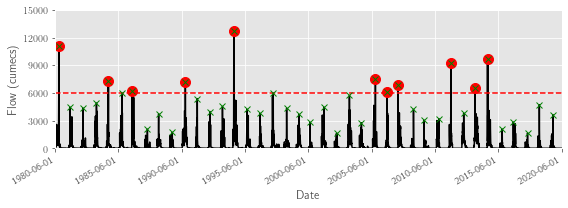

In [5]:
critical_val = 6000
fig = plt.figure(figsize=[8, 3])
data.plot(ax=plt.gca(), color='k')
mask = (year_maxima.values >= critical_val)
plt.plot(max_flow_dates.values[mask], year_maxima.values[mask], 'ro', ms=10)
plt.plot(data.index[[0, -1]], [critical_val]*2, '--r')
plt.plot(max_flow_dates.values, year_maxima.values, 'gx')
plt.xlim(data.index[[0, -1]])
plt.ylim([0, 15000])
plt.yticks([i*3000 for i in range(6)])
plt.xticks([pd.to_datetime(f'{i}-06-01') for i in range(1980, 2021, 5)])
plt.ylabel('Flow (cumecs)')
plt.xlabel('Date')
plt.savefig(os.path.join(FIGURE_FOLDER, 'return_period_2_flow'), dpi=200)

Next, the average inter-arrival time is calculated for the marked data points.

Return period estimated from sample for 6000 cumec is 3.09 years.


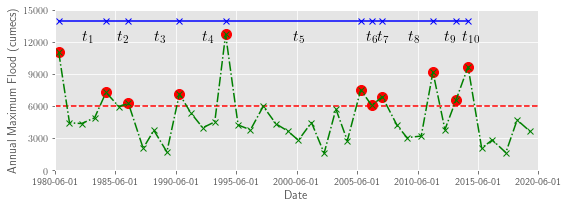

In [6]:
fig = plt.figure(figsize=[8, 3])
mask = (year_maxima.values >= critical_val)
plt.plot(max_flow_dates.values[mask], year_maxima.values[mask], 'ro', ms=10)
plt.plot(data.index[[0, -1]], [critical_val]*2, '--r')
plt.plot(max_flow_dates.values, year_maxima.values, '-.gx')
marked_dates = max_flow_dates.values[mask]
plt.plot(marked_dates, [14000]*sum(mask), '-bx')
for i, d in enumerate(marked_dates[:-1], start=1):
    plt.text(d+(marked_dates[i]-d)/2, 12000, '$t_{'+str(i)+'}$', fontsize=16)
plt.xlim(data.index[[0, -1]])
plt.ylim([0, 15000])
plt.yticks([i*3000 for i in range(6)])
plt.xticks([pd.to_datetime(f'{i}-06-01') for i in range(1980, 2021, 5)])
plt.ylabel('Annual Maximum Flood (cumecs)')
plt.xlabel('Date')
plt.savefig(os.path.join(FIGURE_FOLDER, 'return_period_3_flow'), dpi=200)


interarrival_time_data = np.diff(year_maxima[mask].index)
return_period_sample = sum(interarrival_time_data)/sum(mask)
print('Return period estimated from sample for 6000 cumec is {:0.3} years.'.format(return_period_sample))

## Weibull plotting position estimate for return period

Return period estimated using Weibull plotting position formula for 6000 cumec is 3.7 years.


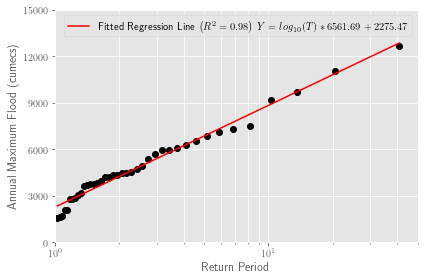

In [7]:
X, P = plotting_position(year_maxima, method='Weibull')
T = 1/P
fig = plt.figure(figsize=[6, 4])
plt.semilogx(T, X, 'ko')
fitted_line_param = np.polyfit(np.log10(T), X, deg=1)
X_est = fitted_line_param[0] * np.log10(T) + fitted_line_param[1]
plt.semilogx(T, X_est, 'r',
             label=r'Fitted Regression Line $\left(R^2={:0.2f}\right)$'.format(
                 np.corrcoef(X, X_est)[0, 1]**2) +
             ' $Y=log_{{10}}(T)*{:4.2f}+{:4.2f}$'.format(*fitted_line_param))
plt.ylim((0, 15000))
plt.yticks([i*3000 for i in range(6)])
plt.xlim((1, 50))
plt.legend(fontsize=10.5)
plt.grid(b=True, which='both')
plt.xlabel('Return Period')
plt.ylabel('Annual Maximum Flood (cumecs)')
plt.savefig(os.path.join(FIGURE_FOLDER, 'plotting_position_weibull'), dpi=200)

return_period_plotting_pos = 10**((critical_val - fitted_line_param[1])
                                  / fitted_line_param[0])
print('Return period estimated using Weibull plotting position formula for 6000 cumec is {:0.3} years.'.format(return_period_plotting_pos))

## Probability paper estimate for return period

Two different distribution (exponential and normal) are used for probability paper. The best fitting distribution is then used for finding the estimate of return period.

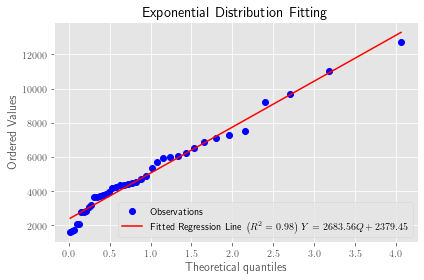

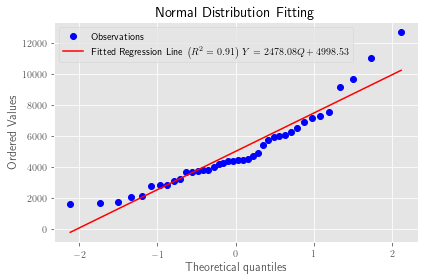

Best fit distribution: Exponential
Return period estimated using Exponential distribution for 6000 cumec is 3.85 years.


In [8]:
# Close handles to previous plots
plt.close('all')
r = []
dist_names, dist_class = ['Exponential', 'Normal'], [stats.expon, stats.norm]
for dist, dist_name in zip(dist_class, dist_names):
    _,_r=stats.probplot(year_maxima, plot=plt, dist=dist)
    r.append(_r)
    plt.title('')
    plt.legend(plt.gca().get_lines(), ['Observations',
                r'Fitted Regression Line $\left(R^2={:0.2f}\right)$'.format(
                _r[-1]**2) +' $Y={:4.2f}Q+{:4.2f}$'.format(
                    *_r[:2])])
    plt.savefig(os.path.join(FIGURE_FOLDER, f'prob_paper_fit_{dist_name}'),
                dpi=200)
    plt.title(dist_name+ ' Distribution Fitting')
    plt.show()
    plt.close()
    
# Selection of best fit distribution
sel_index = 0 if r[0][2]>=r[1][2] else 1
print('Best fit distribution: {}'.format(dist_names[sel_index]))
log_P = -(critical_val-r[sel_index][1])/r[sel_index][0]
return_period_prob_paper =1/np.exp(log_P)
print('Return period estimated using {} distribution for 6000 cumec is {:0.3} years.'.format(dist_names[sel_index], return_period_prob_paper))